In [45]:
# will autoupdate any of the packages imported:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [46]:
import numpy as np
import pyclifford as pc
from numba import njit
from tqdm import tqdm
from matplotlib import pyplot as plt
import seaborn as sns
colors = sns.color_palette("tab10")
import time
from multiprocess import Pool
import os
print("Number of CPUs: ", os.cpu_count())
print("Number of CPUs available: ", len(os.sched_getaffinity(0)))
print("Number of CPUs per task:", int(os.environ['SLURM_CPUS_PER_TASK']))
print("Number of CPUs on node:", int(os.environ['SLURM_CPUS_ON_NODE']))
num_cpus = len(os.sched_getaffinity(0))

Number of CPUs:  20
Number of CPUs available:  8
Number of CPUs per task: 8
Number of CPUs on node: 8


# Lib
Copied from `MIPT.py` to allow for more flexible development.

In [47]:
@njit
def qubit_pos(i, D = 1):
    """Generates a list of qubit positions corresponding to qudit i.

    Args:
        i (int): The qudit position.
        D (int, optional): The number of qubits per qudit. Defaults to 1.

    Returns:
        list: The list of qubit positions.
    """
    return [i * D + j for j in range(D)]

def random_clifford(circ, even = True, D = 1):
    """Adds a layer of random Clifford gates to the circuit.

    Args:
        circ (pc.circuit.Circuit): The circuit to add gates to.
        even (bool, optional): Whether to add gates starting with even or odd qudits. Defaults to True.
        D (int, optional): The number of qubits per qudit. Defaults to 1.
    
    Returns:
        None
    """
    N = circ.N
    assert N % D == 0
    L = int(N / D)

    for i in range(L // 2):
        if even:
            q1 = 2 * i
            q2 = q1 + 1
        else:
            q1 = 2 * i + 1
            q2 = (q1 + 1) % L
        circ.gate(*qubit_pos(q1, D), *qubit_pos(q2, D))

@njit
def generate_measurement_position(L, p, D = 1):
    """Generates a random list of positions to measure.

    Args:
        L (int): The number of qudits in the circuit.
        p (float): The probability of measuring each qudit.
        D (int, optional): The number of qubits per qudit. Defaults to 1.

    Returns:
        list: The list of qubit positions to measure.
    """
    positions = []
    for i in range(L):
        if np.random.rand()<p:
            positions.extend(qubit_pos(i, D))
    return positions

def random_measurement(circ, p, D = 1):
    """Adds a layer of random measurements to the circuit.

    Args:
        circ (pc.circuit.Circuit): The circuit to add measurements to.
        p (float): The probability of measuring each qudit.
        D (int, optional): The number of qubits per qudit. Defaults to 1.

    Returns:
        None
    """
    L = int(circ.N / D)
    pos = generate_measurement_position(L, p, D)
    if pos: # not empty
        circ.measure(*pos)

def create_circuit(L, depth, p, D = 1):
    """Creates a random Clifford circuit with random measurements.
    
    Args:
        L (int): The number of qudits in the circuit.
        depth (int): The number of time steps in the circuit.
        p (float): The probability of measuring each qudit.
        D (int, optional): The number of qubits per qudit. Defaults to 1.
    
    Returns:
        pc.circuit.Circuit: The random Clifford circuit.
    """
    N = L * D
    if p > 0:
        circ = pc.circuit.Circuit(N)
        for _ in range(depth):
            random_clifford(circ, even = True, D = D)
            random_measurement(circ, p, D)
            random_clifford(circ, even = False, D = D)
            random_measurement(circ, p, D)
    else:
        circ = pc.circuit.Circuit(N) # TODO: use tc.circuit.CliffordCircuit for greater speedup
        for _ in range(depth):
            random_clifford(circ, even = True, D = D)
            random_clifford(circ, even = False, D = D)
    return circ

def me_state(L, D = 1):
    """Creates a random maximally entangled state.

    Args:
        L (int): The number of qudits in the state.
        D (int, optional): The number of qubits per qudit. Defaults to 1.
    
    Returns:
        pc.stabilizer.StabilizerState: The maximally entangled state.
    """
    N = L * D
    state = pc.zero_state(N)
    circ = create_circuit(L, L // 2, 0, D)
    circ.forward(state)
    return state

def entropy(state, D = 1, A = None):
    """Calculates the bipartite entanglement entropy of the state.

    Args:
        state (pc.stabilizer.StabilizerState): The state to calculate the entropy of.
        D (int, optional): The number of qubits per qudit. Defaults to 1.
        A (list, optional): The list of qudit positions to calculate the entropy of. Defaults to None (first half of the qudits)

    Returns:
        float: The bipartite entanglement entropy.
    """
    N = state.N
    L = int(N / D)
    if A is None:
        A = [i for i in range(L // 2)]
    return state.entropy([j for i in A for j in qubit_pos(i, D)])

def bip_info(state, D = 1, recip_size = 8):
    """Calculates the bipartite mutual information of two opposite subsystems.

    Args:
        state (pc.stabilizer.StabilizerState): The state to calculate the mutual information of.
        D (int, optional): The number of qubits per qudit. Defaults to 1.
        recip_size (int, optional): The reciprocal size of the subsystems, in terms of L. Defaults to 8.
    
    Returns:
        float: The bipartite mutual information.
    """
    N = state.N
    L = int(N / D)
    assert recip_size > 2
    subsys_size = int(L / recip_size)
    subsys_1 = [i for i in range(subsys_size)]
    subsys_2 = [int(L / 2) + i for i in range(subsys_size)]
    return entropy(state, D, subsys_1) + entropy(state, D, subsys_2) - entropy(state, D, subsys_1 + subsys_2)

def trip_info(state, D = 1, recip_size = 4):
    """Calculates the negative tripartite mutual information of three adjacent subsystems.
    
    Args:
        state (pc.stabilizer.StabilizerState): The state to calculate the mutual information of.
        D (int, optional): The number of qubits per qudit. Defaults to 1.
        recip_size (int, optional): The reciprocal size of the subsystems, in terms of L. Defaults to 4.
    
    Returns:
        float: The negative tripartite mutual information.
    """
    N = state.N
    L = int(N / D)
    assert recip_size > 3

    subsys_size = int(L / recip_size)
    subsys_1 = [i for i in range(subsys_size)]
    subsys_2 = [i + subsys_size for i in range(subsys_size)]
    subsys_3 = [i + 2 * subsys_size for i in range(subsys_size)]

    info_1 = entropy(state, D, subsys_1) + entropy(state, D, subsys_2) + entropy(state, D, subsys_3)
    info_2 = entropy(state, D, subsys_1 + subsys_2) + entropy(state, D, subsys_2 + subsys_3) + entropy(state, D, subsys_3 + subsys_1)
    info_3 = entropy(state, D, subsys_1 + subsys_2 + subsys_3)
    return -info_1 + info_2 - info_3

def evolve_entropy(state, depth, p, D = 1):
    """Computes the bipartite entanglement entropy of the state under random time evolution.

    Args:
        state (pc.stabilizer.StabilizerState): The initial state.
        depth (int): The number of time steps.
        p (float): The probability of measuring each qudit.
        D (int, optional): The number of qubits per qudit. Defaults to 1.

    Returns:
        np.ndarray: An array of shape (depth + 1,) containing the bipartite entanglement entropies.
    """
    N = state.N
    L = int(N / D)
    entropies = [entropy(state, D)]
    for _ in range(depth):
        circ = create_circuit(L, 1, p, D)
        circ.forward(state)
        entropies.append(entropy(state, D))
    return np.array(entropies)

def evolve_entropies(L, depth, p, zero = True, shots = 10, D = 1, logging = True):
    """Computes an ensemble average version of evolve_entropy.

    Args:
        L (int): The number of qudits in the state.
        depth (int): The number of time steps.
        p (float): The probability of measuring each qudit.
        zero (bool, optional): Whether to start from the zero state. Defaults to True.
        shots (int, optional): The number of samples to average over. Defaults to 10.
        D (int, optional): The number of qubits per qudit. Defaults to 1.
        logging (bool, optional): Whether to display a progress bar. Defaults to True.
    
    Returns:
        np.ndarray: An array of shape (2, depth + 1) containing the mean and std of the bipartite entanglement entropies.
    """
    N = L * D
    entropies_raw = []
    if logging:
        for _ in tqdm(range(shots)):
            if zero:
                state = pc.zero_state(N)
            else:
                state = me_state(L, D)
            entropies_raw.append(evolve_entropy(state, depth, p, D))
    else:
        for _ in range(shots):
            if zero:
                state = pc.zero_state(N)
            else:
                state = me_state(L, D)
            entropies_raw.append(evolve_entropy(state, depth, p, D))
    
    entropies_raw = np.array(entropies_raw)
    entropies_mean = np.mean(entropies_raw, axis = 0)
    entropies_std = np.std(entropies_raw, axis = 0, ddof = 1) / np.sqrt(shots)
    return np.array([entropies_mean, entropies_std])


In [48]:
@njit
def xi(L, z1, z2):
    """Calculates xi, as defined by Li et al. in https://arxiv.org/abs/2003.12721.

    Args:
        L (int): The number of qudits in the state.
        z1 (int): The first qudit position.
        z2 (int): The second qudit position.

    Returns:
        float: xi.
    """
    if z1 == z2:
        raise ValueError("z1 and z2 must be different")
    return (np.pi / L / np.sin(np.pi * (z1 - z2) / L)) ** 2

# Dev

In [49]:
L = 256
depth = int(L / 2)
shots = 256
timesteps = 128
D = 1
N = L * D

p = 0.16
YT = 0.61

In [50]:
def sample_all_entropies(state, D = 1):
    result = []
    N = state.N
    L = int(N / D)
    qubits = []
    for i in range(1, int(L / 2) + 1):
        qubits.extend(qubit_pos(i, D))
        x = xi(L, 0, i)
        y = entropy(state, D, qubits)
        result.append((x, y))
    return np.array(result)

In [51]:
def sample(dummy):
    circ = create_circuit(L, depth, p, D)
    state = pc.zero_state(N)
    circ.forward(state)
    buffer = sample_all_entropies(state, D)
    for i in range(timesteps - 1):
        circ = create_circuit(L, 1, p, D)
        circ.forward(state)
        buffer = np.vstack((buffer, sample_all_entropies(state, D)))
    return buffer

In [52]:
with Pool(num_cpus) as pool:
    results = pool.map(sample, range(shots))

In [53]:
results = np.array(results).reshape((-1,int(L / 2),2))

In [54]:
results.shape

(32768, 128, 2)

In [59]:
means = np.mean(results, axis = 0)
stds = np.std(results[:, :, 1], axis = 0, ddof = 1) / np.sqrt(results.shape[0])

Text(0.5, 1.0, 'Entanglement entropy as $\\tau\\to\\infty$, mapped to 2-point function')

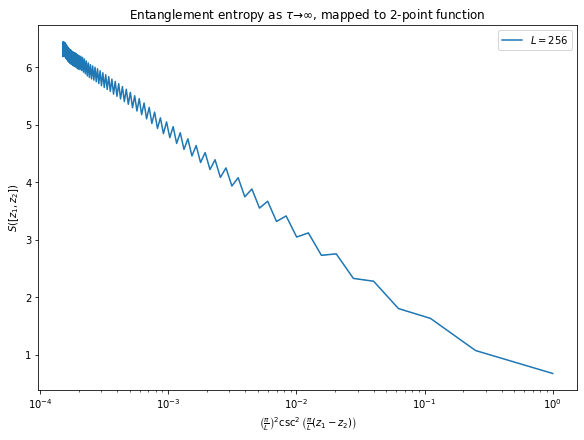

: 

: 

In [60]:
plt.subplots(figsize = (8, 6), layout = "constrained")
plt.plot(means[:, 0], means[:, 1], label = "$L={}$".format(L))
plt.fill_between(means[:, 0], means[:, 1] - stds, means[:, 1] + stds, alpha = 0.5)
plt.xscale('log')
plt.ylabel(r"$S([z_1,z_2])$")
plt.xlabel(r"$\left(\frac{\pi}{L}\right)^2\csc^2\left(\frac{\pi}{L}(z_1-z_2)\right)$")
plt.legend()
plt.title("Entanglement entropy as $\\tau\\to\infty$, mapped to 2-point function")